# 연구목표 설정

- 유사서비스 : 카카오번역, 파파고, 구글번역..
- 언어 감지 하는 방법은 지도학습법을 사용하겟다
  - 알파벳 (26:피쳐)의 빈도 -> en, fr, id, t..
  - 독립변수의 빈도를 보고 레이블(정답,종속변수)를 판단하게 되는 형태 -> 분류(지도학습)
  - 비영어권 제외, 알파벳 사용 국가 분류 총데이터도 제공된 자료만으로 사용(4개국가)
  - 알고리즘의 업데이트 시점은 로그를 축적하여 1만건 누적되면 추가 학습후 갱신하는 방식으로 진행

|step|단계명|수행내용|
|:--:|--:|:--|
|1|연구목표 설정|- 언어를 감지하는 웹서비스이다<br>- 머신러닝의 지도학습법의 분류 알고리즘을 이용하여 분류기를 구현하겠다<br>- 최적화 부분은 생략<br>- 정확도에 대한 정량적인 목표는 생략|
|2|데이터 수집/확보|- 실전:위키피디아에서 텍스트를 웹스크래핑으로 수집하여 데이터를 확보<br>- 프로토타입구현:제공 데이터를 사용하겠다|
|3|데이터 준비|- 전처리(데이터 원재료에서 아파벳을 빼고 모두 제거->정규식)<br>- 빈도 계산, 정규화<br>- 훈련용데이터와 학습용데이터를 75:25로 나눈다 |
|4|데이터 분석|- 영어권 언어별로 알파벳의 출현(사용) 빈도가 다르다는 명제(논문,주장)을 근거를 증명<br>- 탐색적분석,  EDA를 이용하여 표현(막대차트, 선형차트)|
|5|데이터 모델링 구축|- 알고리즘 선택<br>- 학습<br>- 예측<br>-성능평가 및 최적화(생략)<br>-모델덤프|
|6|시스템 통합|-웹서비스구축<br>-모델덤프로드모듈구현<br>-언어감지를 처리하는 모듈 구현<br>-번역 요청 로그처리|

# 데이터 수집/확보

- 실전:위키피디아에서 텍스트를 웹스크래핑으로 수집하여 데이터를 확보
- 프로토타입구현:제공 데이터를 사용하겠다


In [1]:
# 워키피디아는 사이트를 들여다 보니 스크래핑 수준이면 처리가 가능하다
'''
https://ko.wikipedia.org/wiki/방탄소년단
https://en.wikipedia.org/wiki/BTS_(band)
https://fr.wikipedia.org/wiki/BTS_(groupe)
 
위키피디아에서 최초 url의 국가코드를 조정하면 국가별로 진입가능
단, 검색어가 영어권에서 범용적인 부분을 사용하거나 
아니면, 국가별로 리스트업이 필요하다
'''

'\nhttps://ko.wikipedia.org/wiki/방탄소년단\nhttps://en.wikipedia.org/wiki/BTS_(band)\nhttps://fr.wikipedia.org/wiki/BTS_(groupe)\n \n위키피디아에서 최초 url의 국가코드를 조정하면 국가별로 진입가능\n단, 검색어가 영어권에서 범용적인 부분을 사용하거나 \n아니면, 국가별로 리스트업이 필요하다\n'

In [2]:
# URL에 대한 고민은 전제하고, 하나의 사이트에서 처리 루틴을 정리
# 미국 위키피다아를 전제로 처리
target_url = 'https://en.wikipedia.org/wiki/BTS_(band)'
target_url

'https://en.wikipedia.org/wiki/BTS_(band)'

In [3]:
# 웹 스크래핑 관련 모듈 가져오기
# 통신담당 : reguest
# 파싱담당 : BS4, html5lib parser 사용
# (파서 선정이유 속도가 중요한게 아니라, 정확한 처리가 중요)
import urllib.request as req
from bs4 import BeautifulSoup

In [4]:
# 요청
res  = req.urlopen( target_url )
# 파싱
soup = BeautifulSoup( res, 'html5lib' )

In [5]:
# DOM Tree가 생성되었다
type(soup)#, soup

bs4.BeautifulSoup

In [6]:
# 대상 태그들을 모은다
ps = soup.select('#mw-content-text p')
len(ps), type(ps)

(79, list)

In [7]:
# ps에서 한개 뽑아서 텍스트를 출력해 보았다
tmp = list()
for p in ps:
  tmp.append('[%s]' % p.text.strip() )
  #break
# 79개를 다 뽑아서 리스트에 담아라
tmp[:3], tmp[-3:]

(['[]',
  '[]',
  '[BTS (Korean:\xa0방탄소년단; RR:\xa0Bangtan Sonyeondan), also known as the Bangtan Boys, is a seven-member South Korean boy band formed in Seoul in 2010.[3] The septet co-writes and produces much of their output. Originally a hip hop group, their musical style has evolved to include a wide range of genres. Their lyrics, often focused on personal and social commentary, touch on the themes of mental health, troubles of school-age youth, loss, the journey towards loving oneself, and individualism. Their work features references to literature and psychological concepts and includes an alternative universe storyline. The group have staged several world tours.]'],
 ['[]', '[Japanese-language studio albums]', '[]'])

In [8]:
# 텍스트를 모은다, 여러개를 리스트에
# 리스트 내포를 이용하여 79개의 p 태그에서 텍스트를 추출하여 리스트
# 에 구성원으로 추가하시오
tmp = [ p.text.strip() for p in ps]
tmp[:10]

['',
 '',
 'BTS (Korean:\xa0방탄소년단; RR:\xa0Bangtan Sonyeondan), also known as the Bangtan Boys, is a seven-member South Korean boy band formed in Seoul in 2010.[3] The septet co-writes and produces much of their output. Originally a hip hop group, their musical style has evolved to include a wide range of genres. Their lyrics, often focused on personal and social commentary, touch on the themes of mental health, troubles of school-age youth, loss, the journey towards loving oneself, and individualism. Their work features references to literature and psychological concepts and includes an alternative universe storyline. The group have staged several world tours.',
 'The group initially formed as teenagers under Big Hit Entertainment and released their debut single album, 2 Cool 4 Skool (2013). Subsequent work such as their first U.S. Billboard 200 entries The Most Beautiful Moment in Life, Part 2 (2015), The Most Beautiful Moment in Life: Young Forever (2016), and Wings (2016) helped est

In [9]:
# 리스트에 존재하는 문자열들을 한개의 문자열로 통합
src_txt = ' '.join( tmp )
len(src_txt), src_txt[:100]

(72251,
 '  BTS (Korean:\xa0방탄소년단; RR:\xa0Bangtan Sonyeondan), also known as the Bangtan Boys, is a seven-member Sou')

- 영어는 소문자로 통일 (lower)
- 영어를 제외하고는 모두 제거 (정규식)
- 띄어쓰기 기준으로 정도는 남기고 싶다(가독성은 올라간다) (정규식중에 공백은 두자)

In [10]:
# 정규식
import re

In [11]:
# 정규식, 알파벳만 남겨라 -> 
p = re.compile('[^a-zA-Z ]*')
tmp = p.sub( '' ,  src_txt )
tmp.lower()[:100]

'  bts korean rrbangtan sonyeondan also known as the bangtan boys is a sevenmember south korean boy b'

## 제공된 데이터 사용

In [12]:
# 파일을 한번에 다 읽을려면 => 특정 폴더 밑에서 특정 패턴을가진 
# 파일들을 지정해서 목록화
# 파일명 : 언어코드-넘버.txt
# /content/train/en-1.txt

In [13]:
# 파일 리스트 획득
import glob

In [14]:
file_list = glob.glob('./content/train/*.txt')
type(file_list), file_list[:2]

(list, ['./content/train\\en-1.txt', './content/train\\en-2.txt'])

In [15]:
file_list.sort()

In [16]:
file_list

['./content/train\\en-1.txt',
 './content/train\\en-2.txt',
 './content/train\\en-3.txt',
 './content/train\\en-4.txt',
 './content/train\\en-5.txt',
 './content/train\\fr-10.txt',
 './content/train\\fr-6.txt',
 './content/train\\fr-7.txt',
 './content/train\\fr-8.txt',
 './content/train\\fr-9.txt',
 './content/train\\id-11.txt',
 './content/train\\id-12.txt',
 './content/train\\id-13.txt',
 './content/train\\id-14.txt',
 './content/train\\id-15.txt',
 './content/train\\tl-16.txt',
 './content/train\\tl-17.txt',
 './content/train\\tl-18.txt',
 './content/train\\tl-19.txt',
 './content/train\\tl-20.txt']

# 데이터 준비

- 데이터를 읽으면서 알파벳의 빈도를 계산
- 언어코드도 획득해서, 해당 언어에 알페벳의 빈도는 이런 식으로 표현
- 알파벳별 빈도는 (feature), 언어코드는(label)
- train 데이터는 row가 20개(국가별 5개), column(26(알파벳) + 1(답))
- shape => (20,27)

In [17]:
# 텍스트 파일이 하나 확인되면 -> file_list의 개수만큼 반복
  # 언어코드 획득
    # 파일에서 파일명획득 -> 언어코드가 존재한다
    # 언어코드를 추출
  # 알파벳별 빈도수 획득
    # 전처리를 통해서 영어만 둔다
    # 알파벳별 빈도를 계산한다

### 언어코드 획득

In [18]:
# 파일에서 파일명획득 -> 언어코드가 존재한다
# 구조과 규칙이 변하지 않는다는 전제하에서
# file_list[0].split('/')[-1][:2]
# 언어코드를 추출

In [19]:
# 외장함수를 활용하여 처리
import os
# 파일명 획득
# file_list[0].split('/')[-1] 과 결과는 동일
name = os.path.basename( file_list[0] )
name

'en-1.txt'

In [20]:
# 정규식으로 언어코드획득
import re
p         = re.compile( '^[a-z]{2}' )
lang_code = p.match( name ).group()
lang_code

'en'

In [21]:
file_list

['./content/train\\en-1.txt',
 './content/train\\en-2.txt',
 './content/train\\en-3.txt',
 './content/train\\en-4.txt',
 './content/train\\en-5.txt',
 './content/train\\fr-10.txt',
 './content/train\\fr-6.txt',
 './content/train\\fr-7.txt',
 './content/train\\fr-8.txt',
 './content/train\\fr-9.txt',
 './content/train\\id-11.txt',
 './content/train\\id-12.txt',
 './content/train\\id-13.txt',
 './content/train\\id-14.txt',
 './content/train\\id-15.txt',
 './content/train\\tl-16.txt',
 './content/train\\tl-17.txt',
 './content/train\\tl-18.txt',
 './content/train\\tl-19.txt',
 './content/train\\tl-20.txt']

### 알파벳 빈도 계산

In [22]:
# 텍스트 파일을 읽어서 => 알파벳만 남긴다
# 최종 변수명 text

# 텍스트 파일을 열고(I/O)
with open(file_list[0], encoding='utf-8') as f:
  # 읽어서  
  text = f.read().lower()
  # 알파벳만 남기고? (알파벳, 띠어쓰기까지 남기고?)
  p    = re.compile('[^a-z]*')
  text  = p.sub( '' ,  text )#일치되는표현만 (치환)제거시키겠다
  print( text[:100] )
  pass
  # 알파벳만 남긴다

themainhenryfordmuseumbuildinghousessomeoftheclassroomsforthehenryfordacademyhenryfordacademyisthefi


In [23]:
# 알파벳별로 카운트를 담을 그릇 (한개의 이름으로 26개의 정보를 담는그릇)
# 파이썬의 리스트를 사용한다, 수정가능하고, 순서가 존재하므로 적합하다
# a->z 까지는 순서가 존재함으로( ASCII )
counts = [ 0 for n in range(26) ]
counts

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [24]:
[0]*26

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [25]:
# text에서 한글자씩 읽어서 -> a면 counts[0]+=1 -> counts[a-a]+=1
# z -> counts[25]+=1 -> counts[z-a]+=1 
# t -> counts[?]+=1 -> counts[t-a]+=1 
# ord() 특정 문자의 아스키코드값을 리턴
# a-z까지는 연속적으로 아스키값이 배치되어 있다
# 따라서 특정 문자의 위치는 ord('소문자')-ord('a')
ord('a'), ord('z'), (ord('z')-ord('a'))

(97, 122, 25)

In [26]:
counts = [ 0 for n in range(26) ]
ASCII_A = ord('a')
for ch in text:
  #print( ch )
  # 한개뽑인 문자의 아스키값 ord(ch)
  counts[ (ord(ch)-ASCII_A) ] += 1
  #break
print( counts )

[349, 59, 210, 212, 484, 72, 88, 201, 340, 8, 25, 247, 121, 356, 412, 76, 0, 357, 282, 370, 119, 45, 65, 3, 92, 2]


- 데이터를 들여다 보니, 값의 편차가 크다 (최대, 최소등으로 확인)_
- 데이터는 빈도를 표현함으로, 최대 최소의 의미보다는 , 총 빈도에서 특정 알파벳이
- 얼마나 등장했는가가 중요하다 => 이것을 기준으로 정규화처리
- 데이터 준비 단계에서는 데이터의 품질을 향상을 목표로 하고, 주 수단으로 정규화를 사용 한다

In [27]:
sum(counts), len( text )

(4595, 4595)

In [28]:
#list( map( 함수, 데이터덩어리 ) )
# 함수는 map이 자동으로 맴버수만큼 호출한다
# x:맴버 한개 한개,...
def checkNorm( x ):
  #print(x)
  # 알파벳별빈도/총빈도(=총알파벳문자열개수)
  return x / len( text )
frequences = list( map( checkNorm, counts ) ) 
print( sum(frequences), frequences )

1.0 [0.07595212187159957, 0.012840043525571273, 0.04570184983677911, 0.04613710554951034, 0.10533188248095757, 0.015669205658324265, 0.019151251360174103, 0.043743199129488576, 0.07399347116430903, 0.0017410228509249185, 0.00544069640914037, 0.05375408052230685, 0.026332970620239392, 0.07747551686615888, 0.08966267682263329, 0.016539717083786723, 0.0, 0.07769314472252448, 0.061371055495103376, 0.08052230685527748, 0.02589771490750816, 0.009793253536452665, 0.014145810663764961, 0.0006528835690968443, 0.02002176278563656, 0.0004352557127312296]


In [29]:
frequences = list( map( lambda x:x / len( text ), counts ) ) 

In [30]:
# 텍스트 파일 1개에 대한 최종 결과물
print( lang_code, frequences )

en [0.07595212187159957, 0.012840043525571273, 0.04570184983677911, 0.04613710554951034, 0.10533188248095757, 0.015669205658324265, 0.019151251360174103, 0.043743199129488576, 0.07399347116430903, 0.0017410228509249185, 0.00544069640914037, 0.05375408052230685, 0.026332970620239392, 0.07747551686615888, 0.08966267682263329, 0.016539717083786723, 0.0, 0.07769314472252448, 0.061371055495103376, 0.08052230685527748, 0.02589771490750816, 0.009793253536452665, 0.014145810663764961, 0.0006528835690968443, 0.02002176278563656, 0.0004352557127312296]


### 위의 구성 내용을 한칸에 넣어서 함수화 시킨다

In [31]:
import os, re
def paringLangFreq( file_path ):
  # 언어코드 획득  
  name = os.path.basename( file_path )  
  p         = re.compile( '^[a-z]{2}' )
  lang_code = p.match( name ).group()

  # 단어의 빈도
  with open(file_path, encoding='utf-8') as f:
    text = f.read().lower()
    p    = re.compile('[^a-z]*')
    text  = p.sub( '' ,  text )

  counts = [ 0 for n in range(26) ]
  ASCII_A = ord('a')
  for ch in text:
    counts[ (ord(ch)-ASCII_A) ] += 1
    
  frequences = list( map( lambda x:x / len( text ), counts ) ) 

  # 결과 리턴
  return ( lang_code, frequences )

print( paringLangFreq( file_list[0]) )

('en', [0.07595212187159957, 0.012840043525571273, 0.04570184983677911, 0.04613710554951034, 0.10533188248095757, 0.015669205658324265, 0.019151251360174103, 0.043743199129488576, 0.07399347116430903, 0.0017410228509249185, 0.00544069640914037, 0.05375408052230685, 0.026332970620239392, 0.07747551686615888, 0.08966267682263329, 0.016539717083786723, 0.0, 0.07769314472252448, 0.061371055495103376, 0.08052230685527748, 0.02589771490750816, 0.009793253536452665, 0.014145810663764961, 0.0006528835690968443, 0.02002176278563656, 0.0004352557127312296])


In [32]:
# 훈련용 데이터, 테스트용 데이터 로드
# 중간 경로가 train or test
def load_data( path='train' ):
  # 파일 경로 획득 
  file_lists = glob.glob( './content/{}/*.txt'.format(path) )
  # 정답을 담을 리스트
  labels = list()
  freqs  = list()
  # 파일 경로를 한개씩 뽑아서  
  for f in file_lists:
    # 파일 1개당, 정답, 빈도수리스트 리턴
    lang, freq = paringLangFreq( f )
    labels.append( lang )
    freqs.append( freq )
  return { 'labels':labels, 'freqs':freqs }

train_data = load_data()
test_data  = load_data('test')

In [33]:
test_data

{'labels': ['en', 'en', 'fr', 'fr', 'id', 'id', 'tl', 'tl'],
 'freqs': [[0.06782261776891207,
   0.013459304237269558,
   0.03432780201231943,
   0.04881737872377737,
   0.11611389991012516,
   0.020013590828382912,
   0.016002104386330256,
   0.022797518577785572,
   0.07691970450908613,
   0.002411276003419628,
   0.005502093425984787,
   0.03827352638155155,
   0.030097108660864992,
   0.07400425261404239,
   0.08373703939148162,
   0.028321532694710536,
   0.000657620728205353,
   0.07012429031763082,
   0.07955018742190754,
   0.0751222078519915,
   0.02591025669129091,
   0.014774545693680264,
   0.036103377978473884,
   0.005633617571625857,
   0.013086652491286526,
   0.00041649312786339027],
  [0.08028287821720025,
   0.016174278091650972,
   0.03534996861268048,
   0.0383415725047081,
   0.12986503452605147,
   0.016703939108600126,
   0.01895009416195857,
   0.04269656308851224,
   0.07398579723791589,
   0.004462884494664155,
   0.00673846516007533,
   0.043324309478970494,

In [34]:
# 덤프 (현 단계 결과물을 저장)
import json

with open('labels_freqs_data.json', 'w') as f:
  # json 구조로 저장
  json.dump( [train_data, test_data], f )

# 데이터 분석

- 알파벳의 빈도가 영어권 국가별로 다르다!!



In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

%matplotlib inline

In [36]:
# 데이터 로드
# /content/labels_freqs_data.json
with open('labels_freqs_data.json', 'r') as f:
  tmp = json.load( f )
len(tmp)
# 0:train, 1:test

2

In [37]:
# 데이터크기 확인
# 훈련
len( tmp[0]['labels'] ), len( tmp[0]['freqs'] )

(20, 20)

In [38]:
# 테스트
len( tmp[1]['labels'] ), len( tmp[1]['freqs'] )

(8, 8)

In [39]:
# 훈련 데이터를 DataFrame으로 빈도 데이터만 로드
df_freqs = pd.DataFrame( tmp[0]['freqs'] )
df_freqs.head(2)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.075952,0.012840,0.045702,0.046137,0.105332,0.015669,0.019151,0.043743,0.073993,0.001741,...,0.000000,0.077693,0.061371,0.080522,0.025898,0.009793,0.014146,0.000653,0.020022,0.000435
1,0.084178,0.019912,0.030404,0.038870,0.136998,0.017408,0.031239,0.027423,0.075355,0.002623,...,0.005485,0.090140,0.071659,0.077739,0.030643,0.013712,0.013950,0.002027,0.010731,0.000596


In [40]:
df_freqs.shape

(20, 26)

In [41]:
# 훈련 데이터를 DataFrame으로 정답 데이터만 로드
df_labels = pd.DataFrame( tmp[0]['labels'] )
df_labels.head(2)

,0
0,en
1,en


In [42]:
df_labels.shape

(20, 1)

In [43]:
# 컬럼명을 명확하게 조정
# df_labels의 컬러명을  label 로 교체
df_labels.columns = ['label']

In [44]:
df_labels.head(2)

,label
0,en
1,en


In [45]:
# df_freqs의 컬럼명을 a-z까지 변경
from string import ascii_lowercase
ascii_lowercase

'abcdefghijklmnopqrstuvwxyz'

In [46]:
df_freqs.columns = list( ascii_lowercase )
df_freqs.head(2)

,a,b,c,d,e,f,g,h,i,j,...,q,r,s,t,u,v,w,x,y,z
0,0.075952,0.012840,0.045702,0.046137,0.105332,0.015669,0.019151,0.043743,0.073993,0.001741,...,0.000000,0.077693,0.061371,0.080522,0.025898,0.009793,0.014146,0.000653,0.020022,0.000435
1,0.084178,0.019912,0.030404,0.038870,0.136998,0.017408,0.031239,0.027423,0.075355,0.002623,...,0.005485,0.090140,0.071659,0.077739,0.030643,0.013712,0.013950,0.002027,0.010731,0.000596


In [47]:
# df_freqs, df_labels 결합 => (20, 27)
df_tmp = pd.merge( df_freqs, df_labels, left_index=True, right_index=True )
df_tmp.head(2)

,a,b,c,d,e,f,g,h,i,j,...,r,s,t,u,v,w,x,y,z,label
0,0.075952,0.012840,0.045702,0.046137,0.105332,0.015669,0.019151,0.043743,0.073993,0.001741,...,0.077693,0.061371,0.080522,0.025898,0.009793,0.014146,0.000653,0.020022,0.000435,en
1,0.084178,0.019912,0.030404,0.038870,0.136998,0.017408,0.031239,0.027423,0.075355,0.002623,...,0.090140,0.071659,0.077739,0.030643,0.013712,0.013950,0.002027,0.010731,0.000596,en


In [48]:
df_tmp = pd.concat( [df_freqs, df_labels], axis=1 )
df_tmp.head(2)

,a,b,c,d,e,f,g,h,i,j,...,r,s,t,u,v,w,x,y,z,label
0,0.075952,0.012840,0.045702,0.046137,0.105332,0.015669,0.019151,0.043743,0.073993,0.001741,...,0.077693,0.061371,0.080522,0.025898,0.009793,0.014146,0.000653,0.020022,0.000435,en
1,0.084178,0.019912,0.030404,0.038870,0.136998,0.017408,0.031239,0.027423,0.075355,0.002623,...,0.090140,0.071659,0.077739,0.030643,0.013712,0.013950,0.002027,0.010731,0.000596,en


### 피벗 (특정 컬럼에 반복적으로 데이터가 보이면, 그 종류가 한정적)

- 현재 데이터를 일종의 로그가 누적된 데이터이다 
- 이 데이터에서 숨겨진 정보를 추출하기 위해서, 관점을 달리하여 데이터를 재구성
- 국가별 알파벳의 빈도
- row : 국가별 정렬
- column : 알파벳으로 정렬
- index:en, fr, .. column은 a~z 로 재구성해라 -> 피벗테이블


In [49]:
# label값 추출 및 중복제거
df_tmp['label'].unique(), df_tmp.label.unique()

(array(['en', 'fr', 'id', 'tl'], dtype=object),
 array(['en', 'fr', 'id', 'tl'], dtype=object))

In [50]:
# 결과물 (4,26)
df_tmp_pv = df_tmp.pivot_table( index=df_tmp.label )
df_tmp_pv.head(2), df_tmp_pv.shape

(              a         b         c         d         e         f         g  \
 label                                                                         
 en     0.075558  0.018601  0.036565  0.039376  0.124937  0.016977  0.023900   
 fr     0.076183  0.013140  0.036707  0.049217  0.150272  0.012729  0.013278   
 
               h         i         j  ...         q         r         s  \
 label                                ...                                 
 en     0.042127  0.074847  0.002329  ...  0.001592  0.070693  0.070782   
 fr     0.014709  0.077658  0.003138  ...  0.005976  0.077309  0.074177   
 
               t         u         v         w         x         y         z  
 label                                                                        
 en     0.085701  0.026975  0.011627  0.016694  0.002466  0.016232  0.000788  
 fr     0.067647  0.049076  0.013363  0.001796  0.004234  0.004813  0.000915  
 
 [2 rows x 26 columns], (4, 26))

In [51]:
df_tmp_pv = df_tmp.pivot_table( columns=df_tmp.label )
df_tmp_pv.head(2), df_tmp_pv.shape

(label        en        fr        id        tl
 a      0.075558  0.076183  0.160047  0.210537
 b      0.018601  0.013140  0.026276  0.021824, (26, 4))

In [52]:
df_tmp_pv.T

,a,b,c,d,e,f,g,h,i,j,...,q,r,s,t,u,v,w,x,y,z
label,,,,,,,,,,,,,,,,,,,,,
en,0.075558,0.018601,0.036565,0.039376,0.124937,0.016977,0.023900,0.042127,0.074847,0.002329,...,0.001592,0.070693,0.070782,0.085701,0.026975,0.011627,0.016694,0.002466,0.016232,0.000788
fr,0.076183,0.013140,0.036707,0.049217,0.150272,0.012729,0.013278,0.014709,0.077658,0.003138,...,0.005976,0.077309,0.074177,0.067647,0.049076,0.013363,0.001796,0.004234,0.004813,0.000915
id,0.160047,0.026276,0.008391,0.038213,0.085395,0.008259,0.044496,0.017399,0.095626,0.006473,...,0.000036,0.056469,0.061414,0.049494,0.044268,0.003768,0.004730,0.000725,0.012463,0.000807
tl,0.210537,0.021824,0.010842,0.019756,0.041240,0.003260,0.075524,0.014543,0.078540,0.001603,...,0.000680,0.030609,0.054899,0.051996,0.030127,0.002815,0.009956,0.000430,0.025048,0.001396


In [53]:
# a~z가  index, 국가가 컬럼
df_tmp_pv.shape

(26, 4)

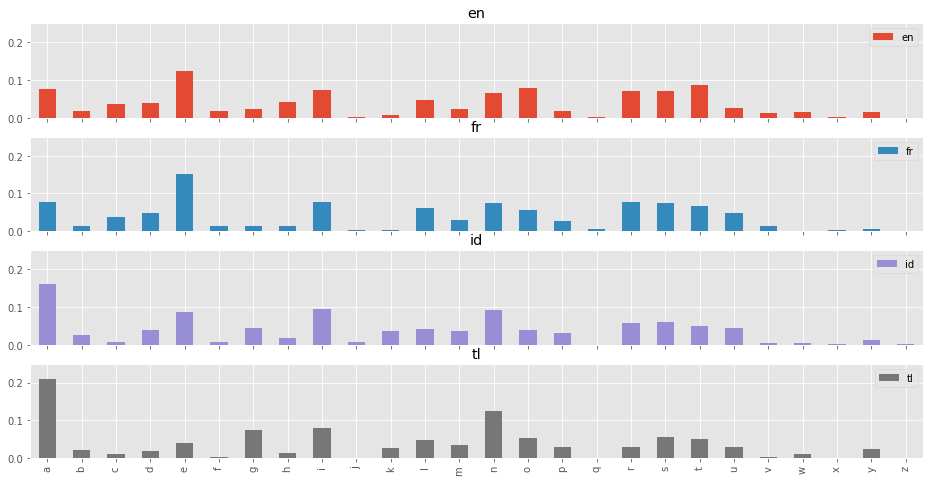

In [54]:
# 바차트
# ggplot 스타일
plt.style.use('ggplot')
# 플로팅, y축의 값을 특정 구간으로 제한하겠다
df_tmp_pv.plot( kind='bar', subplots=True, 
                figsize=(16,8), ylim=(0, 0.25) )
# 저장
plt.savefig('na_per_freqs.png')
# 보이기
#plt.show()

In [55]:
# 단어별로 (a~ z)로 한개의 차트에 국가별로 빈도를 그린다
# 이 차트는 저장한다 => a_freqs.png, b_freqs.png, .. z_freqs.png
# 한개의 차트에 여러값을 표현하여 비중의 차이점을 그린다 
# 데이터는 df_tmp를 이용하여, a만 모아서 국가별로 그리고, b만모아서그리고,..
# 한차트에 겹쳐그려서 데이터의 위치(분포)가 구분되는지, 겹치는지 확인=>히스토그램
# 추가설명
# 차트는 총 26개
# ex) a빈도를 그린다면, 한 차트에 특정국가별로 a만 그린다(국가별로색구분됨)
#     색의 겹침을 보기 위해서 투명값을 부여 alpha=0.4

In [56]:
df_tmp['label'].unique()

array(['en', 'fr', 'id', 'tl'], dtype=object)

In [57]:
# df_tmp에서 label이 en인 데이터만 모아라
# 블리언 인덷싱
df_tmp[ df_tmp['label'] == 'en' ]

,a,b,c,d,e,f,g,h,i,j,...,r,s,t,u,v,w,x,y,z,label
0,0.075952,0.012840,0.045702,0.046137,0.105332,0.015669,0.019151,0.043743,0.073993,0.001741,...,0.077693,0.061371,0.080522,0.025898,0.009793,0.014146,0.000653,0.020022,0.000435,en
1,0.084178,0.019912,0.030404,0.038870,0.136998,0.017408,0.031239,0.027423,0.075355,0.002623,...,0.090140,0.071659,0.077739,0.030643,0.013712,0.013950,0.002027,0.010731,0.000596,en
2,0.071646,0.012172,0.045643,0.032642,0.120055,0.014661,0.025173,0.023513,0.094606,0.002490,...,0.053942,0.087967,0.081051,0.029046,0.018811,0.011895,0.000553,0.017981,0.000553,en
3,0.072210,0.027715,0.029977,0.039593,0.121041,0.016780,0.023567,0.059012,0.065234,0.001508,...,0.059201,0.073341,0.093703,0.024321,0.005090,0.019608,0.006033,0.017534,0.001697,en
4,0.073806,0.020368,0.031099,0.039641,0.141261,0.020368,0.020368,0.056943,0.065046,0.003285,...,0.072492,0.059571,0.095488,0.024967,0.010731,0.023872,0.003066,0.014893,0.000657,en


In [58]:
df_tmp[ df_tmp['label'] == 'en' ]['a']

0    0.075952
1    0.084178
2    0.071646
3    0.072210
4    0.073806
Name: a, dtype: float64

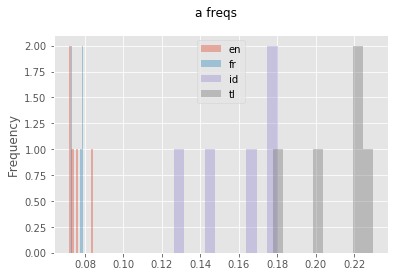

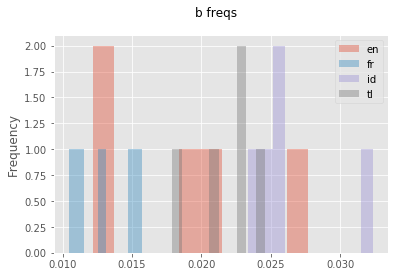

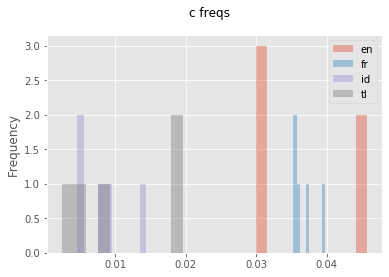

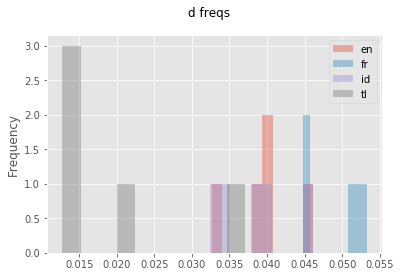

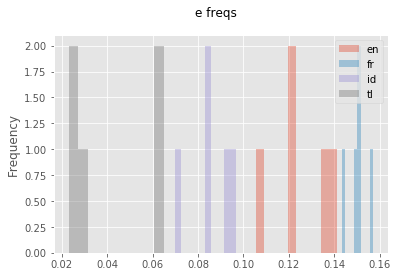

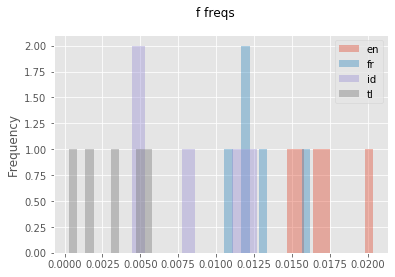

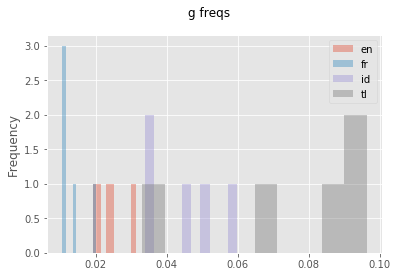

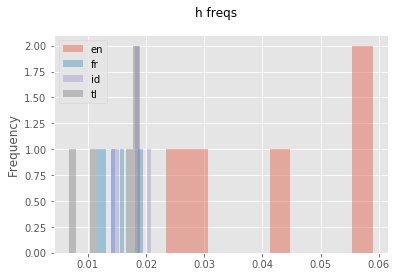

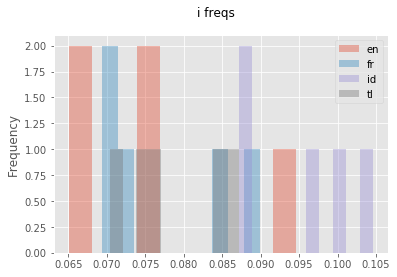

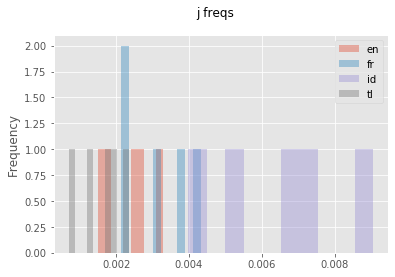

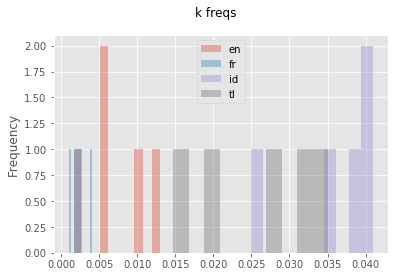

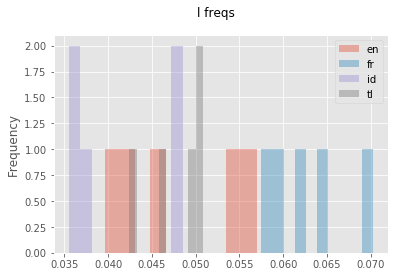

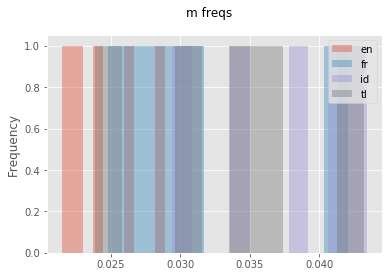

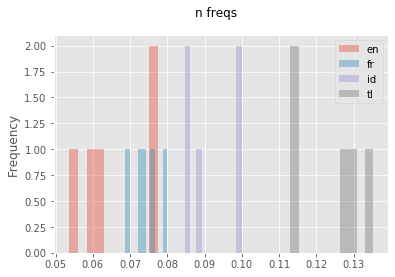

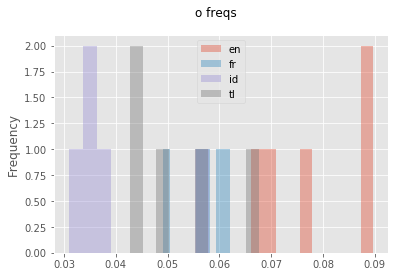

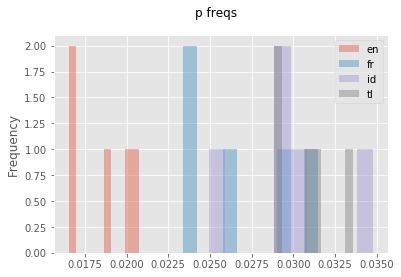

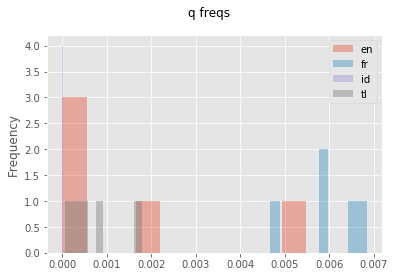

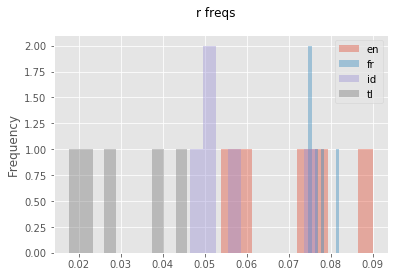

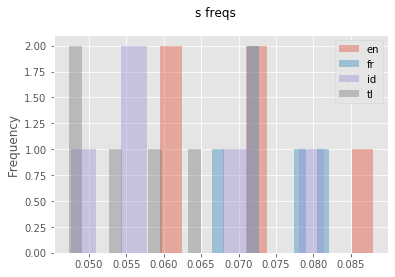

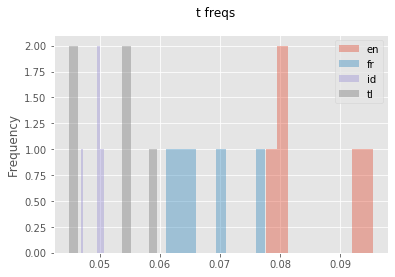

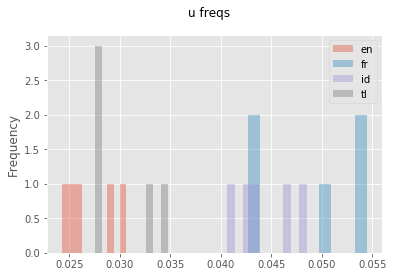

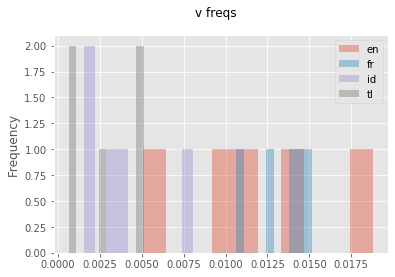

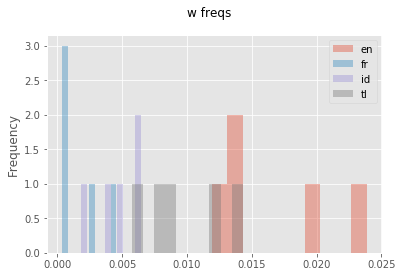

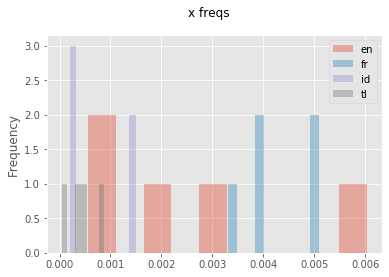

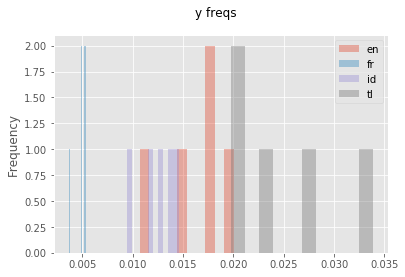

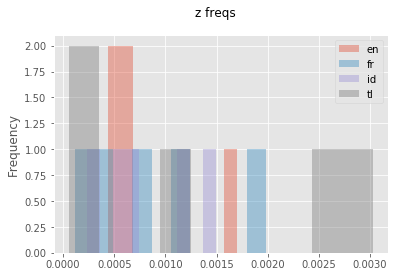

In [59]:
# a-z : 26
for word in ascii_lowercase:
  #print( word )
  # en, fr, id, tl : 4 
  for na in df_tmp['label'].unique():
    # en이면서, a만
    # en만 모아
    tmp = df_tmp[ df_tmp['label'] == na ][word]
    tmp.plot( kind='hist', alpha=0.4, label=na )
    #print( word, na )
  # 차트 1개에 대한 추가분
  plt.legend()                   # 범례표기
  plt.suptitle('%s freqs' % word)# 제목
  plt.savefig('%s.png' % word) # 저장
  plt.show()
  #break

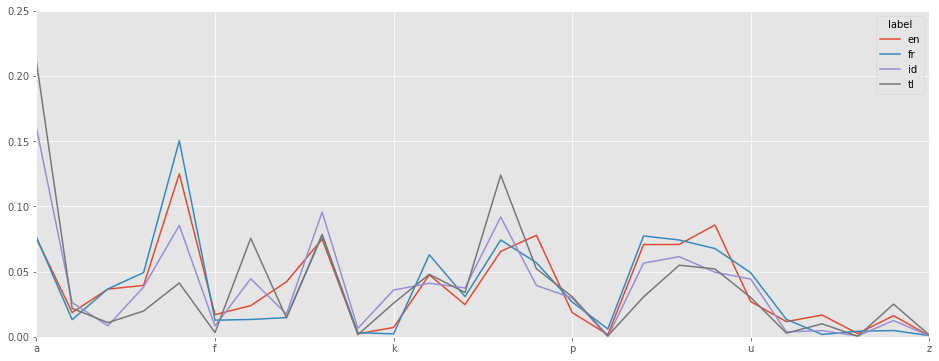

In [60]:
# 선형차트로 최종 다시 확인
df_tmp_pv.plot( kind='line', figsize=(16,6), ylim=(0,0.25) )

# 5. 데이터 모델링 구축



- 알고리즘 선택(선택 시트를 통해서 결정하나, 여기서는 지정)
    - 지도학습 > 분류
    - SVM > SVC
- 학습
    - 데이터( 훈련용, 테스트용)
    - 통계적 모델링 : 훈련용, 테스트용
    - 머신러닝 모델링 : (훈련용, 검증용), 테스트용
    - train 데이터 사용
- 예측
    - test 데이터를 사용
- 성능평가 및 최적화(생략)
    - 분류 > 평가지표 > 정확도 정도 체크
- 모델 덤프
    - 시스템 통합단계에서 신규서비스에 제공하는 알고리즘 파일(학습된 모델이 적제된) 제공

## 5-1. 알고리즘 생성

In [100]:
from sklearn import svm, metrics

In [101]:
clf = svm.SVC( gamma='auto' ) # classification (clf)
clf

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## 5-2. 훈련/테스트 데이터 구성

- 이미 위에서 구성이 완료됨

In [102]:
# 데이터 로드
# /content/labels_freqs_data.json
with open('labels_freqs_data.json', 'r') as f:
  freq = json.load( f )
len(freq)
# 0:train, 1:test

2

In [103]:
# 훈련용 데이터
len(freq[0]['labels']), len(freq[0]['freqs'])

(20, 20)

In [104]:
len(freq[1]['labels']), len(freq[1]['freqs'])

(8, 8)

## 5-3. 학습 (훈련)

In [105]:
clf.fit( freq[0]['freqs'], freq[0]['labels'] )

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## 5-4. 예측

- 한번도 접하지 못한 데이터를 이용하여 예측 수행

In [106]:
# 예측에 사용된 데이터는 학습에 사용된 데이터와 동일 형태를 취해야 한다
predict = clf.predict( freq[1]['freqs'] )

In [107]:
predict

array(['en', 'en', 'fr', 'fr', 'en', 'id', 'tl', 'tl'], dtype='<U2')

## 5-5. 성능평가

- 정확도만 확인
- 목표한 수치에 도착할때까지 이전과정을 반복한다
    - 데이터가 작으면, 더 많이 확보
    - 데이터 준비 과정에서 문제가 있다면 보완
    - 알고리즘이 적절하지 않다면 교차 검증후 확인
    - 하이퍼파라미터 튜닝을 통해서 검증
    - 목표한 수치에 도달할 때까지 반복 ( 에자일 방식 )

In [109]:
metrics.accuracy_score( freq[1]['labels'], predict )

0.875

In [110]:
# metrics.clas 정도까지만 타이핑 하고 텝키 누른다
print( metrics.classification_report( freq[1]['labels'],predict ) )

              precision    recall  f1-score   support

          en       0.67      1.00      0.80         2
          fr       1.00      1.00      1.00         2
          id       1.00      0.50      0.67         2
          tl       1.00      1.00      1.00         2

    accuracy                           0.88         8
   macro avg       0.92      0.88      0.87         8
weighted avg       0.92      0.88      0.87         8



## 5-6. 모델 덤프

- 6단계 시스템 통합에서 사용할 수 있게 제공
- 모델을 향후 어떻게 갱신할 것인가? 이 주제는 생략
    1. 서비스가 진행 
    1. 데이터가 쌓인다 -> 다시 학습가능
    1. 모델을 업그레이드 가능
    1. 실시간 갱신, 주기적 갱신 등등
    1. 학습방식에 대한 고찰(배치학습, 온라인 학습 등)

In [111]:
from sklearn.externals import joblib

In [94]:
# 저장시 년도월일시간 기제
joblib.dump(clf, './clf_model_2020031101113.model')

['./clf_model_2020031101113.model']

In [96]:
# # 저장되는 위치는 자유롭게 결정(코렙은 구글드라이브)
# save_path = '/content/drive/My Drive/clf_model202003110113.model'
# joblib.dump(clf, save_path)

In [97]:
# 정답 저장(레이블 저장)
label_dic = {
    'en':'영어',
    'fr':'프랑스어',
    'tl':'타갈리아어',
    'id':'인도네시아어'
}
label_dic

{'en': '영어', 'fr': '프랑스어', 'tl': '타갈리아어', 'id': '인도네시아어'}

In [99]:
# json 으로 저장
with open('clf_labels.json', 'w', encoding='utf-8') as f:
    json.dump( label_dic, f )

# 시스템 통합

In [61]:
#from IPython.display import Image
#Image( '/content/6.시스템통합_최종산출물.png', width=500 )
# 최종 산출물
# 웹기반(간단한 flask로 정리)
# 머신러닝(SVM.SVC)으로 언어감지, 딥러닝(RNN, 다대다 신경망구성 )으로는 언어번역

## 구동원리

- 1. 사용자가 번역에 필요한 글자를 입력한다
  (알파벳만 사용, 영어권만 해당)  
- 2. 언어감지라는 버튼을 클릭한다
- 3. 언어를 읽어서 서버로 전송
- 4. 서버에서 데이터를 알고리즘이 예측할수 있는 형태로 변환처리
- 5. 예측
- 6. 예측결과를 응답
- 8. 응답 결과를 화면에 표시